### Hierarchical Classfication 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from torchtext.vocab import GloVe
from itertools import combinations
import torch
import os
import time
from sklearn.metrics import classification_report

In [2]:
# Read in balanced dataset 

data_path = '/Users/irsaashraf/Desktop/UChicago/Spring_23/Advanced ML/Project/Irsa_project/balanced_data.csv'
df = pd.read_csv(data_path)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,length,word_count
0,1b7fe21f6b20f176,The Wack Pack \n\nYou're fucking insane and dr...,1,0,1,0,1,0,220,37
1,2b77b61ee27ab6fb,Not according to Wikipedia policy. With respec...,0,0,0,0,0,0,77,11
2,626d12d910b34c40,"You just revert my and a lot of peoples work, ...",1,0,1,0,1,0,222,39
3,2ed8095b9ee464b0,"Frank O'Hara, Anti-Beat? \nSeriously, dude, yo...",0,0,0,0,0,0,544,93
4,86f8607fd0572b9f,"""\n\nreverting\nUser:Baristarim decides that t...",0,0,0,0,0,0,440,72


In [7]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print(len(df))
df[classes].sum()

30588


toxic            15294
severe_toxic      1595
obscene           7987
threat             451
insult            7401
identity_hate     1306
dtype: int64

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [4]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)

2023-05-19 23:02:58.722889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.1


In [8]:
sentences = df['comment_text'].values
y_classes = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
sentences

array(["The Wack Pack \n\nYou're fucking insane and drunk with power. Instead of totally removing big Howard Stern guys like Crackhead Bob and Fred the Elephant Boy, why not just remove the parts that your majesty finds offensive?",
       'Not according to Wikipedia policy. With respect 99.231.50.255  Pavel Golikov.',
       "You just revert my and a lot of peoples work, to improve wiki. So you're a motherfucker. How dare you block an user or users, just because he or she reverted your destructive activite. Shame on you.\nShitface Anna Frodesiak",
       ...,
       'The Criticism section \n\nThe way the criticism section reads at the time of this writing is quite okay, in my opinion. It brings up the most important, on point criticisms of the mainstream in a very readable, well sourced manner, without superfluous ad hominem comments. It also include a reasonable level of Austrian responses to the criticisms. In my view, there is no need for any further changes.\n\nThe Mises-slur is, 

In [9]:
y_classes

array([[1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 0, 0]])

In [11]:
# Create a train, validate and test dataset 
# train 70%, validation 20%, test 10%

X_train, X_rest, y_train, y_rest = train_test_split(sentences, y_classes, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.33, random_state=1)

print("train:", len(X_train), "validation:", len(X_val), "test", len(X_test))

train: 21411 validation: 6148 test 3029


In [12]:
# Preprocess the data

NUM_WORDS = 10000

# Using max_len = 200 for consistency 
MAX_LEN = 200

tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)
# maxlen = max([len(x) for x in X_train])
# 325
# print(f"X_train max len: {maxlen}")
X_train = pad_sequences(X_train, padding='post', maxlen=MAX_LEN)
X_val = pad_sequences(X_val, padding='post', maxlen=MAX_LEN)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_LEN)

### Embedding Matrix 

In [14]:
glove = GloVe(name='6B')

In [15]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    
    vocab_size = len(word_index) + 1 
    # Adding 1 because of reserved 0 index
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    # Load the pre-trained GloVe embeddings
    embeddings_index = {}
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = coefs

    return embedding_matrix

In [16]:
EMBEDDING_DIM = 300
glove_filename = 'glove.6B.300d.txt'
glove_filepath = '/Users/irsaashraf/Desktop/UChicago/Spring_23/Advanced ML/Project/Irsa_project/glove.6B'
glove_filepath_final = os.path.join(glove_filepath, glove_filename)

word_index = tokenizer.word_index
embedding_matrix = create_embedding_matrix(glove_filepath_final, word_index, EMBEDDING_DIM)

In [18]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [31]:
# Use keras to define the model architecture of the CNN

FILTERS= 128
KERNEL_SIZE = 5
ACTIVATION='relu'
ACTIVATION_LAST='sigmoid'
VOCAB_SIZE = len(word_index)+1
DROPOUT = 0.5
UNITS_FIRST = 128
UNITS_SECOND = 6


model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],input_length=MAX_LEN, trainable=False))
model.add(Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=UNITS_FIRST, activation=ACTIVATION))
model.add(Dropout(DROPOUT))
model.add(Dense(units=UNITS_SECOND, activation=ACTIVATION_LAST))

In [32]:
# Compile the model

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 300)          16449300  
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 128)          192128    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                      

In [34]:
# Train the model
EPOCHS = 50
BATCH_SIZE = 16

start_time = time.time()
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE)

print(f'Time taken to complete all {EPOCHS} epochs: {time.time() - start_time} seconds')

Epoch 1/50
1339/1339 [==============================] - 29s 21ms/step - loss: 0.2141 - accuracy: 0.9386 - val_loss: 0.1758 - val_accuracy: 0.9963
Epoch 2/50
1339/1339 [==============================] - 29s 22ms/step - loss: 0.1674 - accuracy: 0.9900 - val_loss: 0.1727 - val_accuracy: 0.9963
Epoch 3/50
1339/1339 [==============================] - 28s 21ms/step - loss: 0.1469 - accuracy: 0.9861 - val_loss: 0.1739 - val_accuracy: 0.9963
Epoch 4/50
1339/1339 [==============================] - 28s 21ms/step - loss: 0.1292 - accuracy: 0.9851 - val_loss: 0.1856 - val_accuracy: 0.9959
Epoch 5/50
1339/1339 [==============================] - 28s 21ms/step - loss: 0.1145 - accuracy: 0.9759 - val_loss: 0.1900 - val_accuracy: 0.9954
Epoch 6/50
1339/1339 [==============================] - 28s 21ms/step - loss: 0.1025 - accuracy: 0.9742 - val_loss: 0.2111 - val_accuracy: 0.9925
Epoch 7/50
1339/1339 [==============================] - 28s 21ms/step - loss: 0.0920 - accuracy: 0.9503 - val_loss: 0.2265 -

In [35]:
# Get prediction metrics

label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names = label_names))

95/95 [==============================] - 2s 17ms/step
               precision    recall  f1-score   support

        toxic       0.88      0.92      0.90      1519
 severe_toxic       0.46      0.31      0.37       175
      obscene       0.81      0.79      0.80       843
       threat       0.70      0.34      0.46        41
       insult       0.70      0.74      0.72       742
identity_hate       0.48      0.37      0.42       126

    micro avg       0.79      0.79      0.79      3446
    macro avg       0.67      0.58      0.61      3446
 weighted avg       0.79      0.79      0.79      3446
  samples avg       0.41      0.40      0.39      3446



/Users/irsaashraf/anaconda3/envs/capp30255/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/irsaashraf/anaconda3/envs/capp30255/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
## SAVE THE MODEL TO DISK ##

model.save("ml_model1_50epochs.h5")
print("Saved model to disk")

Saved model to disk


In [38]:
y_pred

array([[0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

670/670 [==============================] - 11s 16ms/step - loss: 0.0099 - accuracy: 0.7865
Training Accuracy: 0.7865
Validation Accuracy:  0.8066
Testing Accuracy:  0.8260


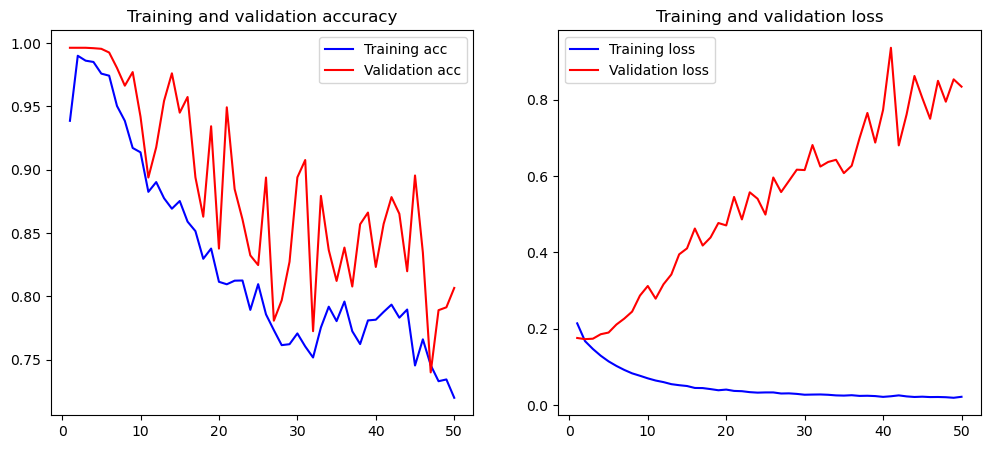

In [36]:
# Plot results 

loss_train, accuracy_train = model.evaluate(X_train, y_train)
print("Training Accuracy: {:.4f}".format(accuracy_train))
loss_val, accuracy_val = model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy_val))
loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_test))
plot_history(history)

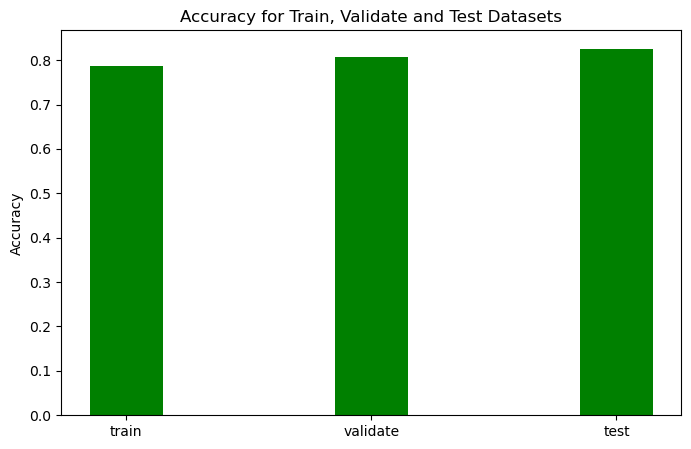

In [41]:
acc_dict = {'train': accuracy_train, 'validate':accuracy_val, 'test':accuracy_test}
x_ = list(acc_dict.keys())
values = list(acc_dict.values())

  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(x_, values, color ='green',
        width = 0.3)
 
# plt.xlabel("Dataset")
plt.ylabel("Accuracy")
plt.title("Accuracy for Train, Validate and Test Datasets")
plt.show()

Training accuracy is the lowest while testing is the highest. Model is not overfitting at all.

In [24]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()